# Titanic - Machine Learning from Disaster

Датасет взят из https://www.kaggle.com/c/titanic/data

In [1]:
#импортируем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#загружаем данные
train = pd.read_csv('../data/titanic/train.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Survived - таргетная переменная. Бинарный признак,выжил ли пассажир.

# Подготовка данных и EDA

In [3]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
# Посмотрим количество пустых значений
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

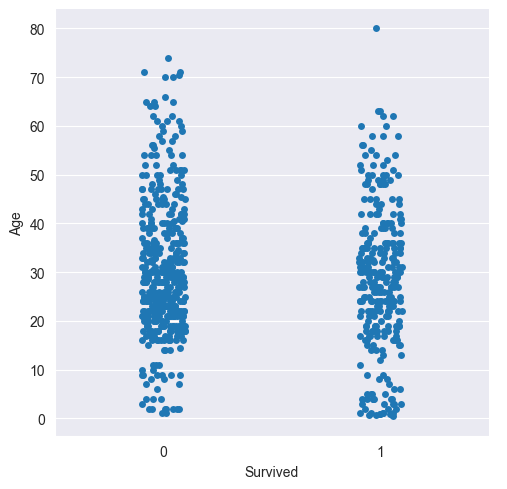

In [5]:
sns.catplot(data=train,x='Survived',y='Age')

Пустые значения Age заполним средним,

Пустые значения Embarked удалим из данных,

И дропнем колонку Cabin,т.к. она скорее пустая чем несет информацию.

In [6]:
train['Age'] = train['Age'].fillna(train['Age'].mean())

In [7]:
train['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [8]:
#61, 829
train[~train['Embarked'].isin(['S','C','Q'])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [9]:
train = train.drop([61,829])

In [10]:
train = train.drop('Cabin',axis=1)

In [11]:
# Проверяем
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [12]:
non_numeric_col = train.loc[:,train.dtypes==object].columns
train[non_numeric_col].head(10)

,Name,Sex,Ticket,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,S
4,"Allen, Mr. William Henry",male,373450,S
5,"Moran, Mr. James",male,330877,Q
6,"McCarthy, Mr. Timothy J",male,17463,S
7,"Palsson, Master. Gosta Leonard",male,349909,S
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,347742,S
9,"Nasser, Mrs. Nicholas (Adele Achem)",female,237736,C


Для не числовых колонок:
Name и Ticket дропнем,
Для всех остальных применим One Hot Encoding

In [13]:
non_numeric_col = non_numeric_col.drop(['Name', 'Ticket'])
train = train.drop(['Name','Ticket'],axis=1)

In [14]:
for col in non_numeric_col:
    one_hot = pd.get_dummies(train[col],prefix=col,drop_first=True)
    train = pd.concat([train,one_hot],axis=1)

In [15]:
train = train.drop(['Sex','Embarked'],axis=1)

In [16]:
train.head(10)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,22.000000,1,0,7.2500,True,False,True
1,2,1,1,38.000000,1,0,71.2833,False,False,False
2,3,1,3,26.000000,0,0,7.9250,False,False,True
3,4,1,1,35.000000,1,0,53.1000,False,False,True
4,5,0,3,35.000000,0,0,8.0500,True,False,True
5,6,0,3,29.699118,0,0,8.4583,True,True,False
6,7,0,1,54.000000,0,0,51.8625,True,False,True
7,8,0,3,2.000000,3,1,21.0750,True,False,True
8,9,1,3,27.000000,0,2,11.1333,False,False,True
9,10,1,2,14.000000,1,0,30.0708,False,False,False


# Обучение модели и подбор параметров

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X = train.drop('Survived',axis=1)
y = train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', LogisticRegression())])

In [18]:
from sklearn.model_selection import GridSearchCV
c = np.linspace(0.001,10,30)

param_grid = ({'model__penalty': ['l1', 'l2','elasticnet'],
               'model__C': c})

search = GridSearchCV(pipe,param_grid)
search.fit(X_train,y_train)

print(search.best_score_,search.best_params_)


0.7974490298433959 {'model__C': np.float64(2.4145517241379313), 'model__penalty': 'l2'}


C:\Users\chest\PycharmProjects\ml_alg\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
300 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\chest\PycharmProjects\ml_alg\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\chest\PycharmProjects\ml_alg\.venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\chest\PycharmProjects\ml_alg\.venv\Lib\sit

In [19]:
final_pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', LogisticRegression(penalty='l2', C=2.4145517241379313))])

final_pipe.fit(X_train,y_train)

score = final_pipe.score(X_test,y_test)
print(score)

0.7696629213483146


# Предсказание на тесте и подготовка CSV

In [20]:
test = pd.read_csv('../data/titanic/test.csv')

test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [21]:
test['Age'] = test['Age'].fillna(test['Age'].mean())
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())

In [22]:
for col in non_numeric_col:
    one_hot = pd.get_dummies(test[col],prefix=col,drop_first=True)
    test = pd.concat([test,one_hot],axis=1)

In [23]:
test = test.drop(['Name','Sex','Ticket','Cabin','Embarked'],axis=1)

In [24]:
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,892,3,34.5,0,0,7.8292,True,True,False
1,893,3,47.0,1,0,7.0000,False,False,True
2,894,2,62.0,0,0,9.6875,True,True,False
3,895,3,27.0,0,0,8.6625,True,False,True
4,896,3,22.0,1,1,12.2875,False,False,True


In [25]:
submission = pd.DataFrame()
pred = final_pipe.predict(test)


submission['PassengerId'] = test['PassengerId']
submission['Survived'] = pred

In [26]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [27]:
submission.to_csv('submission.csv',index=False)